In [38]:
import numpy as np
pi = np.pi
pi2i = pi*2j
from matplotlib import pyplot as plt
from time import time
from scipy.sparse.linalg import gmres

In [39]:
# some aux functions
def cplx2tuple(z):
    return np.real(z), np.imag(z)

# intro
I solved the interior 2d stokes problem on the circle in this jupyter notebook, which serves as a basis for further solution of this problem

In [40]:
# number of points
n = 1024

# points on the interval [0,2*pi] as parametrization 
a = np.linspace(0,2*np.pi,n+1)[:-1]
# step-size, this can either be a single scalar in case of arc-length parametrization, or a sequence otherwise. 
h = 2*np.pi / n

# complex coordinates of points on the curve 
t = np.exp(a*1j)

# parametrization derivatives
dt_da = t*1j

# boundary conditions
v = np.zeros(n)
u = 1-(t.imag)**2
h2 = u
h1 = -v

# curvature, this is the curvature of unit circle. 
curvature = np.ones(n)

The kernels and BI eq can be greatly simplified in this specific case, compare to the original case in L. Greengard's paper. In this case, it is 

$$
K_1'(t_i,t_j) = \frac{-h}{\pi} \Im(\frac{d_j}{dt})\\
K_2'(t_i,t_j) = \frac{-h}{2\pi i} (\frac{-d_j}{\bar{dt}} + \frac{\bar{d_j}dt}{\bar{dt}^2}) 
$$ 
where $dt = t_i-t_j$, $d_j$ is the derivative of the parametrization. 

And in the limiting case of $i=j$, the kernels should be 

$$
K_1'(t_i,t_i) = \frac{h}{2\pi}\kappa_i |d_i| \\
K_2'(t_i,t_i) = \frac{-h}{2\pi} \kappa_i d_i^2/ |d_i|
$$

In [41]:
def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -h * np.imag(d/dt) / np.pi
        K2 = -h * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [42]:
K1, K2 = kernels(t,dt_da,h,curvature)

this calculation can be vectorized for speeding up, but I guess it needs to handle the case of i == j more carefully. 

My integral equation does not contain any singular term, this could lead to inaccuracy and convergence, I guess. 

Should I transfer this into a real equation for the solution?? Or is it I can just live with the complex equation? How to deal with the complex conjugates though... 

The integral equation is of the following form

$$
(I+K_1+K_2\mathfrak C) \omega = h
$$ where $\mathfrak C$ is a symbol for conjugation. 

This can be discreticized in the the points of our choice and then seperate the real and imaginary matrix equation so that 

$$
\begin{pmatrix}
I+\Re(K_1+K_2) & \Im(-K_1+K_2) \\
\Im(K_1 + K_2) & I+\Re(K_1-K_2)
\end{pmatrix}
\begin{pmatrix}
\Re \omega\\
\Im \omega
\end{pmatrix} = 
\begin{pmatrix}
\Re h\\
\Im h
\end{pmatrix}
$$

In [43]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real

In [44]:
rhs = np.concatenate((h1,h2))

In [45]:
omega,_ = gmres(A,rhs)
#omega = np.linalg.solve(A,rhs)

In [46]:
omega = omega[:n] + 1j*omega[n:]

In [47]:
def evaluation(z,omega,t,h,dt_da):
    
    d_t = dt_da*h
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW

# error analysis

Let's pretend that $5h$ rule is true in this case. since $5h = \frac{10\pi}{1024} \approx 0.03$, so for $|z|\le 0.97$, there should be good convergence. 

# error on points $|z|\le 0.97$


In [48]:
grid_density = 1000
radius = 0.97
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
circle_grid = np.array([(x,y) for x in np.linspace(-1,1,grid_density) for y in np.linspace(-1,1,grid_density) if x**2 + y**2 <= radius**2])
circle_grid_X, circle_grid_Y = circle_grid.T
circle_grid_t = circle_grid_X + 1j*circle_grid_Y

circle_grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in circle_grid_t])
true_values = 1j*np.array([1-y**2 for x,y in circle_grid])

error = (np.abs(circle_grid_values - true_values))
relative_error = error/np.abs(true_values)

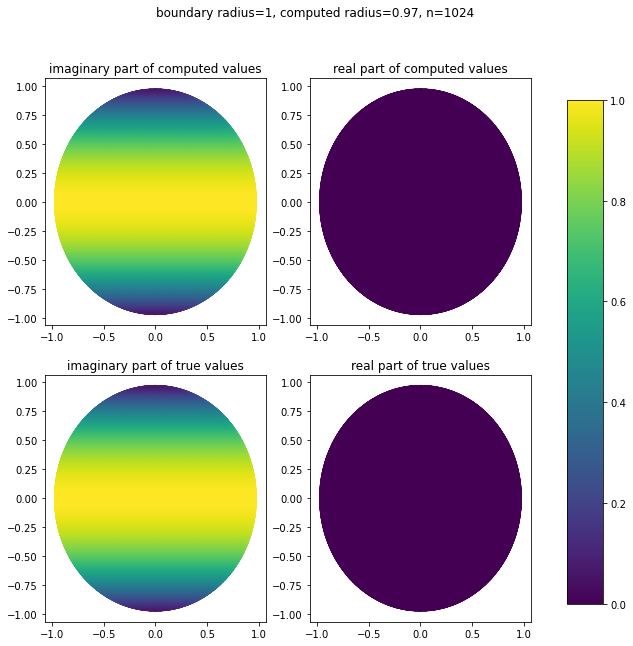

In [49]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

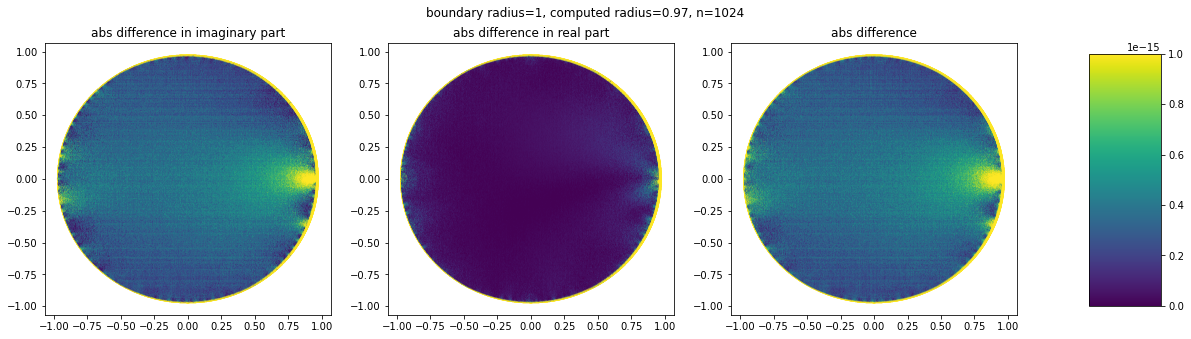

In [50]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).imag),s=1,vmin=0,vmax=1e-15)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).real),s=1,vmin=0,vmax=1e-15)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values)),s=1,vmin=0,vmax=1e-15)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

In [51]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 1024 r= 0.97
error for velocity
max 1.3856598794858553e-12 	mean 1.7054724508231395e-15
relative error for velocity: mean and max
max 7.680790305409165e-12 	mean 4.095042100250178e-15


This is **not far away** from machine precision, and agrees with the $5h$ rule. 

# error on points $|z|\le 0.95$


In [52]:
grid_density = 1000
radius = 0.95
# evaluations close to radius 1 would result in catastrophic errors, therefore I will evaluate for a radius a bit smaller than 1
circle_grid = np.array([(x,y) for x in np.linspace(-1,1,grid_density) for y in np.linspace(-1,1,grid_density) if x**2 + y**2 <= radius**2])
circle_grid_X, circle_grid_Y = circle_grid.T
circle_grid_t = circle_grid_X + 1j*circle_grid_Y

circle_grid_values = np.array([evaluation(z,omega,t,h,dt_da) for z in circle_grid_t])
true_values = 1j*np.array([1-y**2 for x,y in circle_grid])

error = (np.abs(circle_grid_values - true_values))
relative_error = error/np.abs(true_values)

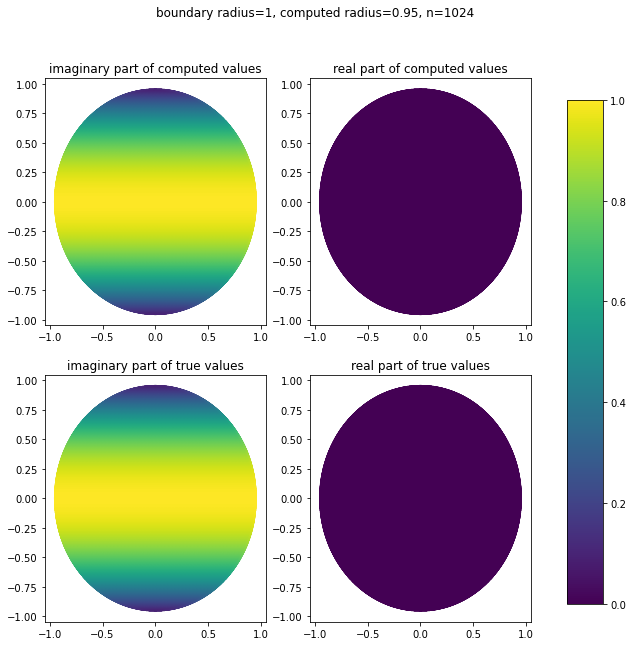

In [53]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.imag,s=1,vmin=0,vmax=1)
axes[0,0].set_title('imaginary part of computed values',)

axes[0,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=circle_grid_values.real,s=1,vmin=0,vmax=1)
axes[0,1].set_title('real part of computed values',)

im = axes[1,0].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.imag,s=1,vmin=0,vmax=1)
axes[1,0].set_title('imaginary part of true values')

axes[1,1].scatter(x=circle_grid_X,y=circle_grid_Y,c=true_values.real,s=1,vmin=0,vmax=1)
axes[1,1].set_title('real part of true values')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

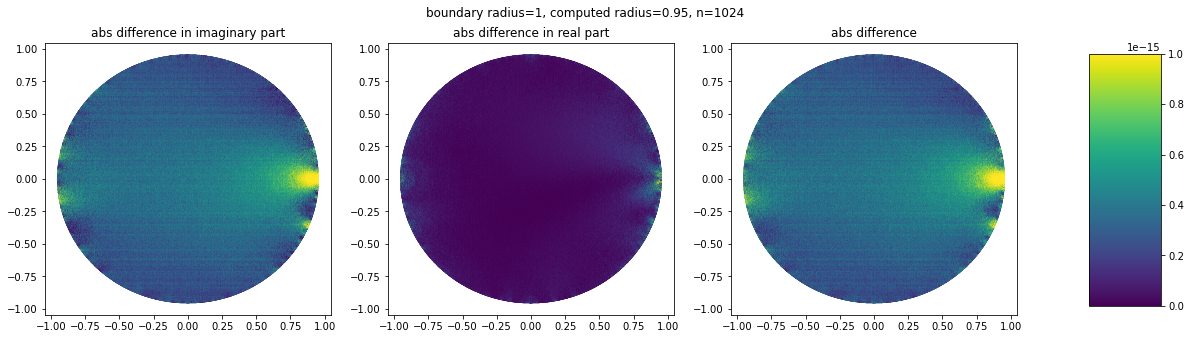

In [54]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).imag),s=1,vmin=0,vmax=1e-15)
axes[0].set_title('abs difference in imaginary part')

axes[1].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values).real),s=1,vmin=0,vmax=1e-15)
axes[1].set_title('abs difference in real part')

im = axes[2].scatter(x=circle_grid_X,y=circle_grid_Y,c=np.abs((circle_grid_values-true_values)),s=1,vmin=0,vmax=1e-15)
axes[2].set_title('abs difference')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('boundary radius=1, computed radius=' + str(radius)+ ', n=' + str(n))
print()

In [55]:
print('n=',n,'r=',radius)
print('error for velocity')
print('max', np.max(error), '\tmean', np.mean(error))

print('relative error for velocity: mean and max')
print('max', np.max(relative_error),'\tmean', np.mean(relative_error))

n= 1024 r= 0.95
error for velocity
max 2.8664485694572914e-15 	mean 3.7067955455123894e-16
relative error for velocity: mean and max
max 5.49535783880548e-15 	mean 5.208208031644263e-16
